In [11]:
## 16. 강화학습 ##
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from functools import partial


## GPU 메모리 관리 ##
#1번 방법
config = tf.ConfigProto()
config.gpu_options.allow_growth = True #메모리 수요에 따라 할당

'''주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. 

Tensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'''

'주의할 점은, 이 옵션은 메모리의 증식만 가능하다는 것. 연산이 끝나고 메모리가 필요없는 상황이라고 해서 할당된 메모리를 반납하지 않는다. \n\nTensorflow 측에서는 그럴 경우 더 심한 메모리 파편화를 일으킬 수도 있다고 하니 판단은 독자의 몫.'

In [12]:
import os, sys

# 맷플롯립 설정
from IPython.display import HTML
%matplotlib inline
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
plt.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

# 정책탐색

소프트웨어 에이전트가 행동을 결정하기 위해 사용하는 알고리즘을 <b style="font-size:1.4em;">정책</b>이라고 한다.

![policy](images/policy.png)

정책은 정해져 있는 알고리즘이 아니기 때문에, 어떠한 알고리즘도 될 수 있다. 예를들어 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 청소기가 있다고 하자. 이 청소기의 정책은 매 초마다 어떤 확률 $p$ 만큼 전진할 수도 있고, 또는 ($1-p$)의 확률로 랜덤하게 $-r$과 $+r$ 사이에서 회전하는 것일 수도 있다. 이 정책에는 무작위성이 포함되어 있으므로 <b style="font-size:1.1em;background-color:#AFA">확률적 정책(stochastic policy)</b>라고 한다.

이러한 정책을 가지고 '30분 동안 얼마나 많은 먼지를 수집할 것인가'에 대한 문제를 해결하기 위해 어떻게 로봇 청소기를 훈련(training) 시킬 수 있을까? 로봇 청소기 예제에는 변경이 가능한 두 개의 <b style="font-size:1.1em;background-color:#AFA">정책 파라미터(policy parameter)</b>가 있는데, 확률 $p$와 각도의 범위 $r$이다. $p$와 $r$은 다양한 조합이 될 수 있는데 이처럼 정책 파라미터의 범위를 <b style="font-size:1.1em;background-color:#AFA">정책 공간(policy space)</b>라고 하며, 정책 공간에서 가장 성능이 좋은 파라미터를 찾는 것을 <b style="font-size:1.1em;background-color:#AFA">정책 탐색(policy search)</b>라고 한다.

정책 탐색에는 다음과 같은 방법들이 있다.
<ul>
<li><b>단순한(naive) 방법</b> : 다양한 파라미터 값들로 실험한 뒤 가장 성능이 좋은 파라미터를 선택한다.</li>
<li><b>유전 알고리즘(genetic algorithm)</b> : 기존의 정책(부모)에서 더 좋은 정책(자식)을 만들어 내는 과정(진화)를 통해서 좋은 정책을 찾을 때까지 반복하는 방법이다.</li>
<li><b>정책 그래디언트(PG, policy gradient)</b> : 정책 파라미터에 대한 보상(reward)의 그래디언트(gradient)를 평가해서 높은 보상의 방향을 따르는 그래디언트로(즉, 경사상승법 gradient ascent) 파라미터를 업데이트하는 최적화 방법이다.</li>
</ul>

## ※렌더링 이슈 해결하기

일부 환경(Cart-Pole을 포함하여)은 rgb_array 모드를 설정하더라도 별도의 창을 띄우기 위해 디스플레이 접근이 필수적입니다. 일반적으로 이 창을 무시하면 됩니다. 주피터가 헤드리스(headless) 서버로 (즉 스크린이 없이) 실행중이면 예외가 발생합니다. 이를 피하는 한가지 방법은 Xvfb 같은 가짜 X 서버를 설치하는 것입니다. xvfb-run 명령을 사용해 주피터를 실행합니다:

$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

주피터가 헤드리스 서버로 실행 중이지만 Xvfb를 설치하기 번거롭다면 Cart-Pole에 대해서는 다음 렌더링 함수를 사용할 수 있습니다:

In [13]:
## 주피터노트북에서 OpenAt Gym 사용하기

from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # 문제없음, OpenAI 짐의 렌더링 함수를 사용합니다
except Exception:
    openai_cart_pole_rendering = False  # 가능한 X 서버가 없다면, 자체 렌더링 함수를 사용합니다

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # OpenAI 짐의 렌더링 함수를 사용합니다
        return env.render(mode="rgb_array")
    else:
        # Cart-Pole 환경을 위한 렌더링 (OpenAI 짐이 처리할 수 없는 경우)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # 파랑 초록 빨강
        pole_col = 0x669acc # 파랑 초록 빨강

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

obs.shape : (4,)
obs : [-0.0081624   0.00426673  0.01323699 -0.03983201]
img.shape : (400, 600, 3)


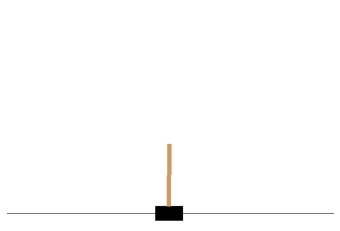

In [14]:
## OpenAt Gym
import gym

env = gym.make("CartPole-v0") #인공지능 모델이 동작할 환경을 만듬
obs = env.reset() #환경을 초기화
img = render_cart_pole(env, obs)

print('obs.shape :', obs.shape)
print('obs :', obs) #[ 카트위치, 속도, 막대기 각도, 각속도]
print('img.shape :', img.shape)
plot_cart_pole(env, obs) #화면에 환경 출력

In [15]:
env.action_space #Discrete(2), 가능한 행동 표시, 0(왼쪽)과 1(오른쪽)가능 

Discrete(2)

In [16]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)

print('obs :', obs) #새로운 관측값
print('reward :', reward) #보상
print('done :', done) #True이면 에피소드가 끝난 것(막대가 쓰러짐), 에피소드가 끝나면 화나경을 다시 사용하기 전 초기화 필요
print('info :', info) #다른 환경인 경우 추가적인 정보가 이 딕셔너리에 담김, 이 데이터는 훈련에 사용되면 안된다

obs : [-0.00807706  0.19919638  0.01244035 -0.32830931]
reward : 1.0
done : False
info : {}


In [17]:
def basic_policy(obs):
    angle = obs[2]
    #막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 가속, 오른쪽으로 기울어지면 카트를 오른쪽으로 가속
    return 0 if angle <0 else 1

frames, totals = [], []
for episode in range(20):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000):  # 영원히 실행되지 않게 최대 스텝을 1000번으로 설정
        img = render_cart_pole(env, obs)
        frames.append(img)
        
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)
    
print('totals mean :', np.mean(totals)) #게임 결과의 평균값
print('totals std :', np.std(totals)) #게임 결과의 표준편차
print('totals min :', np.min(totals)) #게임 결과의 최소값
print('totals max :', np.max(totals)) #게임 결과의 최대값

# ! apt-get update && apt-get install -y ffmpeg
# ! conda install -c conda-forge ffmpeg
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

totals mean : 42.55
totals std : 6.873681691786434
totals min : 25.0
totals max : 56.0


## 신경망 정책

이 신경망은 관측(obs)을 입력으로 받고 실행할 행동(action)에 대한 <b style="background-color:#AFA">확률을 출력</b>한다. 그런다음 <b style="background-color:#AFA">출력된 확률에 따라 랜덤하게 행동</b>을 선택하여 수행한다.

![rlnn](images/rlnn.png)

이처럼 가장 높은 점수의 행동을 바로 선택하지 않고 신경망이 출력한 확률을 랜덤하게 행동을 선택하는 이유는, 에이전트(agent)가 <b style="background-color:#AFA">새로운 행동을 탐험(exploring)</b> 하는 것과 <b style="background-color:#AFA">잘 할 수 있는 행동을 활용(exploiting)</b>하는 것 사이에 균형이 잘 맞게끔 하기 위해서다. 이를 교재에서는 다음과 같은 비유를 들어 설명하고 있다.

<ul>
어떤 음식점에 처음 방문했다고 하자. 모든 메뉴가 좋아 보여서 아무거나 골랐는데, 이 음식이 맛있었다면 다음에 다시 이 메뉴를 주문할 가능성이 높을 것이다. 하지만, 이 확률이 100%가 되어서는 안되는데 그 이유는 다른 더 맛있는 메뉴를 전혀 시도해보지 않을 것이기 때문에, 이를 방지하기 위해 확률을 100%라고 설정하지 않는다.
</ul>

카트폴 문제는 과거의 행동과 관측은 무시해도 상관없지만 다른 문제의 경우에는 현재의 관측 뿐만 아니라 과거의 관측도 고려해야한다. 이런 경우에는 가장 가능성 있는 현재의 상태를 추정하기 위해 <b style="background-color:#AFA">몇 개의 지난 관측을 사용</b>하는 것이 좋다.

In [25]:
tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1 # 왼쪽으로만 가속할 확률 출력

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # 행동 0(왼쪽)에 대한 확률

# 추정된 확률을 기반으로 랜덤하게 행동 선택
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1) #각 정수에 대한 로그 확률을 사용해 num_samples 만큼의 정수를 독립적으로 선택

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy) #추정된 확률과 타깃 확률 사이의 교차 엔트로피를 최소화함, 일반적인 지도학습과 같음

saver = tf.train.Saver()

# 훈련
n_environments = 10
n_iterations = 1000 #에피소드 개수

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # angle<0 이면 1. 그렇지 않으면 0
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "save_model/my_policy_net_basic.ckpt")

for env in envs:
    env.close()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

frames = render_policy_net("save_model/my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

INFO:tensorflow:Restoring parameters from save_model/my_policy_net_basic.ckpt


In [32]:
print('totals mean :', np.mean(totals)) #게임 결과의 평균값
print('totals std :', np.std(totals)) #게임 결과의 표준편차
print('totals min :', np.min(totals)) #게임 결과의 최소값
print('totals max :', np.max(totals)) #게임 결과의 최대값

totals mean : 42.55
totals std : 6.873681691786434
totals min : 25.0
totals max : 56.0


## 행동평가 : 신용할당 문제

일반적으로 보상은 드물(sparse)고 지연(delayed)되어 난다. 예를 들어 CartPole에서 에이전트가 100스텝 동안 막대의 균형을 유지했을 경우, 100번의 행동(action) 중에 어떤 것이 좋고/나쁜지를 알지 못한다. 다만 알 수 있는 것은 막대가 마지막 행동 뒤에 쓰러졌다는 것만 알 수 있다. 하지만 마지막 행동 때문에 막대가 쓰러졌다고는 볼 수 없는데, 이러한 것을 <b style="background-color:#AFA">신용 할당 문제(credit assignment problem)</b>라고 한다. 즉, <b style="background-color:#FAA">에이전트가 보상을 받았을 때 어떤 행동 때문에 받았는지 알기 어렵다.</b>

이러한 문제를 해결하기 위해 주로 사용하는 전략은 행동이 일어난 후 각 단계마다 <b style="background-color:#AFA">할인 계수(discount factor) $\gamma$</b>를 적용한 보상을 모두 합하여 행동을 평가하는 것이다.

할인 계수의 역할은 다음과 같다.

<ul>
    <li>할인 계수 $\gamma$가 <b style="background-color:#AFA">0에 가까우면 미래의 보상보다 현재의 보상을 더 중요하게 취급</b> 한다, <b style="background-color:#AFA">1에 가까우면 미래의 보상이 현재의 보상만큼 중요하게 고려</b>된다.</li>
    <li>일반적으로 할인 계수는 0.95 ~ 0.99 이다.</li>
    <li>$\gamma = 0.95$ 이면, 13 스텝만큼의 미래서 받는 보상은 당장 받는 보상에 비해 약 절반 정도의 가치가 된다($0.95^{13} \approx 0.5$).</li>
</ul>
    
아래의 그림에서 처럼 에이전트가 오른쪽으로 3번 이동하기로 결정했을 경우, 첫 번째 스텝에서 +10, 두 번째 스텝에서 0, 세 번째 스텝에서 -50의 보상을 받는다고 할 때, 할인 계수 $\gamma = 0.8$을 적용하게 되면, 첫 번째 행동의 전체 보상은 $10 + \gamma \times 0 + \gamma^{2} \times (-50) = -22$가 된다.

![discount](images/discount.png)

이렇게 할인 계수 $\gamma$를 적용한 보상의 합을 수식으로 나타내면 다음과 같다. ($n$ = 전체 스텝, $t$ = 스텝)

$$
\begin{align*}
R_{t} &amp;= r_{t} + \gamma r_{t+1} + \gamma^{2} r_{t+2} + \cdots + \gamma^{n-t} r_{n} \\ &amp;= r_{t} + \gamma \left( r_{t+1} + \gamma \left( r_{t+2} + \cdots \right) \right) \\ &amp;= r_{t} + \gamma R_{t+1}
\end{align*}
$$

## 정책 그래디언트 (PG, Policy Gradient)

정책 그래디언트(PG)는 높은 보상을 얻는 방향의 그래디언트로 정책(policy)의 파라미터를 최적화하는 알고리즘이다. 인기있는 PG 알고리즘 중 하나는 REINFORCE 알고리즘이다.

REINFORCE의 방법은 다음과 같다.
<ol>
    <li>먼저 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그래디언트를 계산한다.아직 이 그래디언트를 적요하지는 않는다.</li>
    <li>몇 번의 에피소드를 실행한 다음, 각 행동의 점수를 계산한다.</li>
    <li>한 행동 점수가 양수이면 선택될 가능성이 높도록 1번에서 계산한 그래디언트를 적용한다. 만약, 음수일 경우 덜 선택 되도록 반대의 그래디언트를 적용한다. (그래디언트 벡터와 행동 점수를 곱해주면 된다.)</li>
    <li>마지막으로 모든 결과 그래디언트 벡터의 평균을 구한 다음 경사 하강법을 수행한다.</li>
</ol>

In [34]:
def discount_rewards(rewards, discount_rate): #할인 계수 적용
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate #현재에서 멀어지면 보상의 중요도가 줄어듬
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate): #보상값 정규화
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [35]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [36]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [52]:
tf.reset_default_graph()

n_inputs = 4
n_hidden = 16
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer() #tf.keras.initializers.he_normal()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) #왼쪽으로 갈 확률을 출력해야 해서 0 ~ 1 사이의 값이 나와야 함
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy) #가중치 벡터/변수 쌍 반환
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = [] #업데이트 된 가중치 벡터 저장
grads_and_vars_feed = [] #업데이트 된 가중치 벡터/변수 저장

for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed) #업데이트 된 가중치 적용
save_model = tf.train.Saver()

env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250 #훈련 반복 횟수
save_iterations = 10
discount_rate = 0.95

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(n_iterations):
        print("\r반복: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        
        #10번에 1번씩 가중치 업데이트
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        
        sess.run(training_op, feed_dict=feed_dict) #업데이트 된 가중치 적용
        
        if iteration % save_iterations == 0:
            save_model.save(sess, "save_model/my_policy_net_pg.ckpt")

env.close()

반복: 249

In [54]:
frames = render_policy_net("save_model/my_policy_net_pg.ckpt", action, X, n_max_steps=10000)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

INFO:tensorflow:Restoring parameters from save_model/my_policy_net_pg.ckpt


## 마르코프 결정 과정

이 과정은 정해진 개수의 상태를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이된다. 상태 $s$에서 상태 $s'$로 전이하기 위한 확률은 고정되어 있으며, 메모리가 없기 때문에 과거 상태에 상관없이 $(s, s')$ 쌍에만 의존하는데, 이러한 성질을 마코프 성질(Markov property)이라고 한다.

<br/>

아래의 그림은 4개의 상태를 가진 마코프 체인의 예제다. 상태 $S_0$에서 시작한다고 했을 때, 다음 스텝에서 $S_0$에 있을 확률은 $0.7$이다. $0.2$의 확률로 $S_1$로 전이됐을 경우 $S_2$로 전이될 확률이 0.9이기 때문에 $S_2$로 갈 가능성이 높다. $S_2$로 갔을 경우 $1.0$의 확률로 다시 $S_1$로 돌아오게 된다. 만약, $0.1$의 확률로 $S_3$으로 전이 된다면, 영원히 $S_3$에 남게되는데, 이 상태를 <b style="background-color:#AFA">종료 상태(terminal state)</b>라고 한다.

![mc](images/mc.png)

MDP의 특징

<ul>
    <li>각 스텝에서 에이전트(agent)는 여러 가능한 행동(action) 중 하나를 선택 가능</li>
    <li>전이 확률은 선택된 행동에 따라 달라지며, 어떤 상태로의 전이는 보상(음수 또는 양수)을 반환</li>
    <li>그리고 에이전트의 목적은 시간이 지남에 따라 보상을 최대화하기 위한 정책을 찾는 것</li>
</ul>

### MDP 예시

아래의 그림은 MDP의 예제이며, 다음과 같은 과정이 있다.

<ul>
    <li>3개의 상태와 각 스텝마다 선택 가능한 독립적인 행동을 최대 3개까지 가지고 있다.</li>
    <li>상태 $S_0$에서 시작하면 에이전트는 행동 $a_0, a_1, a_2$ 중 하나를 선택할 수 있다. $a_0$을 선택할 경우 +10의 보상을 받고, 다시 $S_0$으로 돌아온다.</li>
    <li>상태 $S_1$에서는 가능한 행동이 $a_0, a_2$ 2개 뿐이다. $a_2$를 선택할 경우 -50의 보상(패널티)을 받고, $S_2$로 이동한다.</li>
    <li>상태 $S_2$에서는 가능한 행동이 $a_1$ 뿐이며, $0.8$의 확률로 +40의 보상을 받으며 $S_0$로 이동하게 된다.</li>
    <li>이러한 과정을 통해, 에이전트는 시간이 지남에 따라 가장 많이 보상을 받을 수 있는 정책(policy)를 찾게 된다.</li>
</ul>

![mdp](images/mdp.png)

## 벨만 최적 방정식

어떤 상태 $s$의 최적의 <b style="background-color:#FAA">상태</b> 가치(optimal state value) $V^{*}(s)$ 를 추정하는 방법이다.
이 값은 에이전트가 상태 $s$ 에 도달한 후 최적으로 행동한다고 가정하고 <b style="background-color:#AFA">평균적으로 기대할 수 있는 할인된 미래 보상(discounted future reward)의 합</b>이다.
에이전트가 최적으로 행동하면 아래의 벨만 최적 방정식(Bellman Optimality Equation)이 적용된다는 것을 알 수 있다.

$$
V^{*}(s) \leftarrow \max_{a}{\sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot V^{*}(s') \right]}}
$$

<ul>
    <li>$T(s,a,s')$ : 에이전트가 행동 $a$를 선택했을 때 상태 $s$ → $s'$로 전이될 확률</li>
    <li>$R(s,a,s')$ : 에이전트가 행동 $a$를 선택해서 상태 $s$ → $s'$로 이동했을 때의 보상</li>
    <li>$\gamma$ : 할인 계수</li>
    <li>에이전트가 최적으로 행동하면 현재 상태의 최적 가치는 하나의 최적 행동으로 인해 평균적으로 받게돌 보상과 이 행동이 유발할 수 있는 가능한 모든 다음 상태의 최적 가치의 기대치를 합한 것과 같다는 의미</li>
</ul>

<h3>모든 상태 가치를 0으로 초기화 한 뒤, 위의 식을 가지고 여러번 반복(value iteration)하여 상태 가치를 업데이트 해주게 되면, 최적의 상태 가치에 수렴하게 된다.</h3>

## Q-가치 반복 알고리즘

벨만 최적 방정식은 최적의 상태 가치를 아는 것은 정책을 평가할 때 유용하지만, 에이전트는 어떻게 행동해야 하는지에 대해서는 알지못한다. 이에 Bellman은 Q-Value라고 부르는 <b style="background-color:#FAA">최적의 상태 행동(state-action value)을 추정</b>할 수 있는 알고리즘을 만들었다. 상태-행동 $(s, a)$ 쌍의 최적의 Q-가치(Q-함수)인 $Q^{*}(s,a)$ 는 상태 $s$에 도달해서 행동 $a$를 선택하고 이 행동의 <b style="background-color:#AFA">평균적으로 기대할 수 있는 할인된 미래 보상의 합</b>이다. 여기서도 마찬가지로 에이전트가 이 행동 이후에 최적으로 행동할 것이라고 가정한다.

Q-Value Iteration 알고리즘 또한, Q-가치의 추정을 모두 0으로 초기화 한 후 아래의 식을 통해 업데이트 한다.

$$
Q_{k+1}(s, a) \leftarrow \sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot \max_{a'}{Q_{k}(s', a')} \right]}
$$
최적의 Q-가치를 구하면 최적의 정책인 $\pi^{*} (s)$는 다음과 같다.$$
\pi^{*}(s) = \underset{a}{\text{argmax}} Q^{*}(s,a) 
$$

In [102]:
#MDP 적용

nan = np.nan  # 불가능한 행동을 나타냄
T = np.array([  # 형태 = [s, a, s'], 행동을 할 확률
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
    ])
R = np.array([  # 형태 = [s, a, s'], 보상
        [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
        [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50]],
        [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
    ])
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -inf

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 # 모든 가능한 행동 초기화
    
discount_factor = 0.95 #할인계수가 바뀌면 보상을 위한 정책도 바뀜
n_iterations = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([T[s, a, sp] * (R[s, a, sp] + discount_factor * np.max(Q_prev[sp])) for sp in range(3)])
            
print(Q)

[[21.88646117 20.79149867 16.854807  ]
 [ 1.10804034        -inf  1.16703135]
 [       -inf 53.8607061         -inf]]


## 시간차(Temporal Difference) 학습과 Q-Learning

독립적인 행동(action)으로 이루어진 강화학습 문제는 보통 MDP로 모델링될 수 있지만 학습 초기에 에이전트는 전이 확률($T(s, a, s')$)에 대해 알지 못하며, 보상($R(s, a, s')$)이 얼마나 되는지 알지 못한다. 그렇기 때문에, 보상에 대해 알기 위해서는 적어도 한번씩은 각 상태(state)와 전이를 경험해야 한다. 그리고 전이 확률에 대해 신뢰할만한 추정을 얻으려면 여러 번 경험을 해야 한다.

<b style="font-size:1.2em">시간차 학습</b>
<ul>
    <li>가치 반복 알고리즘과 매우 유사하지만 에이전트가 MDP에 대해 일부 정보만 알고 있을 때를 다룰 수 있도록 변형 한 것</li>
    <li>일반적으로 에이전트가 초기에 가능한 상태와 행동만 알고 있고 다른 것은 모른다고 가정</li>
    <li>에이전트는 탐험 정책을 사용해 MDP를 탐험</li>
    <li>TD 학습 알고리즘이 실제로 관측된 전이와 보상에 근거하여 상태가치의 추정을 업데이트 하는 식으로 진행</li>
</ul>

<b style="font-size:1.2em">시간차(TD) 학습 알고리즘</b>

$$
V_{k+1}(s) \leftarrow (1-\alpha)V_{k}(s) + \alpha \left( r + \gamma \cdot V_k(s') \right)
$$
$\alpha$ : 학습률(learning rate), 예를 들어 0.01

각 상태 s에서 이 알고리즘은 에이전트가 이 상태를 떠났으 때 얻을 수 있는 당장의 보상과 나중에 기대할 수 있는 보상을 더한 이동 평균(최적으로 행동한다고 가정하여)을 저장.

<b style="font-size:1.2em">Q-Learning 알고리즘</b>

Q-Learning 알고리즘은 전이 확률과 보상을 초기에 알지 못하는 상황에서 Q-value Iteration 알고리즘을 적용한 것이다.

$$
Q_{k+1}(s, a) \leftarrow (1-\alpha) Q_{k}(s, a) + \alpha \left(r + \gamma \cdot \max_{a'}{Q_k(s', a')} \right)
$$
각 $(s, a)$ 쌍마다 행동 $a$를 선택해 상태 $s$를 떠났을 때 받을 수 있는 보상 $r$과 나중에 기대할 수 있는 보상을 더한 이동평균 값이다.

In [104]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0  # 상태 0에서 시작

Q = np.full((3, 3), -np.inf)  # 불가능한 행동은 -inf

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  
    
for iteration in range(n_iterations): #충분히 반복하면 최적의 Q-가치에 수렴
    a = np.random.choice(possible_actions[s])  # (랜덤하게) 행도선택
    sp = np.random.choice(range(3), p=T[s, a])  # T[s, a]를 사용하여 다음 상태를 선택
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = ((1- learning_rate) * Q[s, a] + 
               learning_rate * (reward + discount_factor * np.max(Q[sp])))
    s = sp  # 다음 상태로 이동
    
print(Q)

[[  4.6191093    1.41503465   1.16622061]
 [  0.                 -inf -15.49579965]
 [        -inf  14.27340511         -inf]]


## 탐험정책

탐험 정책(exploration policy)를 사용해 MDP를 충분히 탐험해야 Q-Learning이 동작한다. 이때 탐험 정책이 랜덤하게 이루어 진다면, 운이 나쁜 경우 극단적으로 오랜 시간이 걸릴 수 있다. 랜덤한 방법 보다 더 나은 방법으로는 $\varepsilon $-greedy policy를 사용하는 것이다.

<ul>
    <li>각 스텝에서 $\varepsilon$의 확률로 랜덤하게 행동</li>
    <li>$1-\varepsilon$ 확률로 그 순간 가장 높은 Q-value를 선택하여 행동</li>
    <li>$\varepsilon $은 높은 곳(1.0)에서 시작해어 점점 감소(0.05)되는 것이 일반적</li>
</ul>

$\varepsilon $-greedy policy의 장점은 완전한 랜덤 정책에 비해 Q-가치 추정이 점점 더 향상되기 때문에 <b style="background-color:#AFA">환경에서 관심 있는 부분을 살피는 데 점점 더 많은 시간을 사용.</b>
그럼에도 여전히 MDP의 알려지지 않은 지역을 방문하는 데 일정 시간을 사용.

다른 방법으로는 탐험의 가능성에 의존하는 대신 이전에 많이 시도하지 않았던 행동을 시도하도록 탐험 정책을 강조하는 방법이 있다. 이 방법은 아래의 식처럼 Q-value 추정에 보너스를 추가하는 방식으로 구현한다.

$$
Q(s, a) \leftarrow (1-\alpha) Q(s, a) + \alpha \left( r + \gamma \cdot \max_{a'}{f \left(Q(s', a'), N(s', a') \right)} \right)
$$

<ul>
    <li>$N(s', a')$ : 상태 $s'$에서 행동 $a'$를 선택한 횟수</li>
    <li>$f(q, n)$ : $f(q, n) = q + K/(1+n)$과 같은 탐험 함수</li>
</ul>


## 심층 Q-네트워크

Q-Learning의 가장 치명적인 문제는 대규모의 상태와 행동을 가진 MDP에는 적용하기 어렵다는 것이다. 예를 들어, '미스 팩맨' 게임의 가능한 상태의 개수는 $2^{250} \approx  10^{75}$ 보다 크다.

이러한 문제를 해결하기위해 Q-value를 추정하기 위해 사용하는 DNN을 DQN(Deep Q-Network)이라고 한다. DQN을 훈련시키기 위해서는 타겟값이 필요한데, 타겟값은 다음과 같이 구할 수 있다.

$$
\text{Target = } Q^{*}(s, a) \approx r + \gamma \cdot \max_{a'}{Q(s', a')}
$$

<b style="font-size:1.1em">근사 Q-value를 상태 $s$에서 행동 $a$를 했을 때 관측된 보상 $r$과 그 이후에 최적으로 행동해서 얻은 할인된 가치를 합한 값에 가능한 가깝게 되도록 해야함.</b>

구체적으로 말하면 타겟인 근사 Q-value와 추정된 Q-value의 제곱 오차를 최소화하는 방향으로 훈련시킬 수 있다.

#### 

다음은 딥마인트가 제안한 DQN 알고리즘에는 두 가지 중요한 변경 사항이다.
<ul>
    <li>Replay memory에 경험 데이터를 저장하여, 각 반복마다 훈련 배치를 랜덤하게 샘플링해준다. 이렇게 해줌으로써 훈련 배치의 겨엄 데이터 사이에 있는 상관관계(correlation)을 감소시켜 훈련 성능을 높인다.</li>
    <li>딥마인드의 DQN은 두 개의 DQN을 사용한다</li>
    <ul>
        <li>Online DQN : 훈련 반복마다 플레이하고 학습한다.</li>
        <li>Target DQN : 타겟 Q-value를 계산할 때만 사용된다. 일정한 간격으로 Online-DQN의 가중치가 Target DQN으로 복사된다.</li>
        <li>두 개의 네트워크를 구성함으로써 훈련 과정을 안정화시키는 데 도움을 준다.</li>
    </ul>
</ul>

### 참고자료
#### https://www.youtube.com/watch?v=w9GwqPx7LW8    - Lecture 6: Q-Network
#### https://www.youtube.com/watch?v=Fcmgl8ow2Uc
#### https://www.youtube.com/watch?v=MF_Wllw9VKk
#### https://www.youtube.com/watch?v=S1Y9eys2bdg   - Lecture 7: DQN
#### https://www.youtube.com/watch?v=Fbf9YUyDFww
#### https://www.youtube.com/watch?v=ByB49iDMiZE
#### https://www.youtube.com/watch?v=TdA0APWRCx0